In [1]:
#warnings
import warnings
warnings.filterwarnings('ignore')

# manejo bbdd
import pandas as pd
import numpy as np
import datetime

#gráficas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#estadística
import math
from scipy.stats import norm
from scipy import stats #para box-cox entre otros
from scipy.stats import skew

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#modelos y evaluación
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
data=pd.read_csv('Data/marketing_customer_analysis.csv') 
data.tail(3)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
9131,TD14365,California,8163.890428,No,Extended,Bachelor,2/6/11,Unemployed,M,0,...,37,3,2,Corporate Auto,Corporate L2,Offer1,Branch,790.784983,Four-Door Car,Medsize
9132,UP19263,California,7524.442436,No,Extended,College,2/3/11,Employed,M,21941,...,3,0,3,Personal Auto,Personal L2,Offer3,Branch,691.200000,Four-Door Car,Large
9133,Y167826,California,2611.836866,No,Extended,College,2/14/11,Unemployed,M,0,...,90,0,1,Corporate Auto,Corporate L3,Offer4,Call Center,369.600000,Two-Door Car,Medsize


In [3]:
data.dtypes

Customer                          object
State                             object
Customer Lifetime Value          float64
Response                          object
Coverage                          object
Education                         object
Effective To Date                 object
EmploymentStatus                  object
Gender                            object
Income                             int64
Location Code                     object
Marital Status                    object
Monthly Premium Auto               int64
Months Since Last Claim            int64
Months Since Policy Inception      int64
Number of Open Complaints          int64
Number of Policies                 int64
Policy Type                       object
Policy                            object
Renew Offer Type                  object
Sales Channel                     object
Total Claim Amount               float64
Vehicle Class                     object
Vehicle Size                      object
dtype: object

In [4]:
numerical=data.select_dtypes(include=np.number)
numerical.columns

Index(['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies',
       'Total Claim Amount'],
      dtype='object')

In [5]:
numerical.head()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,2763.519279,56274,69,32,5,0,1,384.811147
1,6979.535903,0,94,13,42,0,8,1131.464935
2,12887.431650,48767,108,18,38,0,2,566.472247
3,7645.861827,0,106,18,65,0,7,529.881344
4,2813.692575,43836,73,12,44,0,1,138.130879


In [6]:
categorical=data.select_dtypes(object)
categorical.columns

Index(['Customer', 'State', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code',
       'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

## Distribuciones

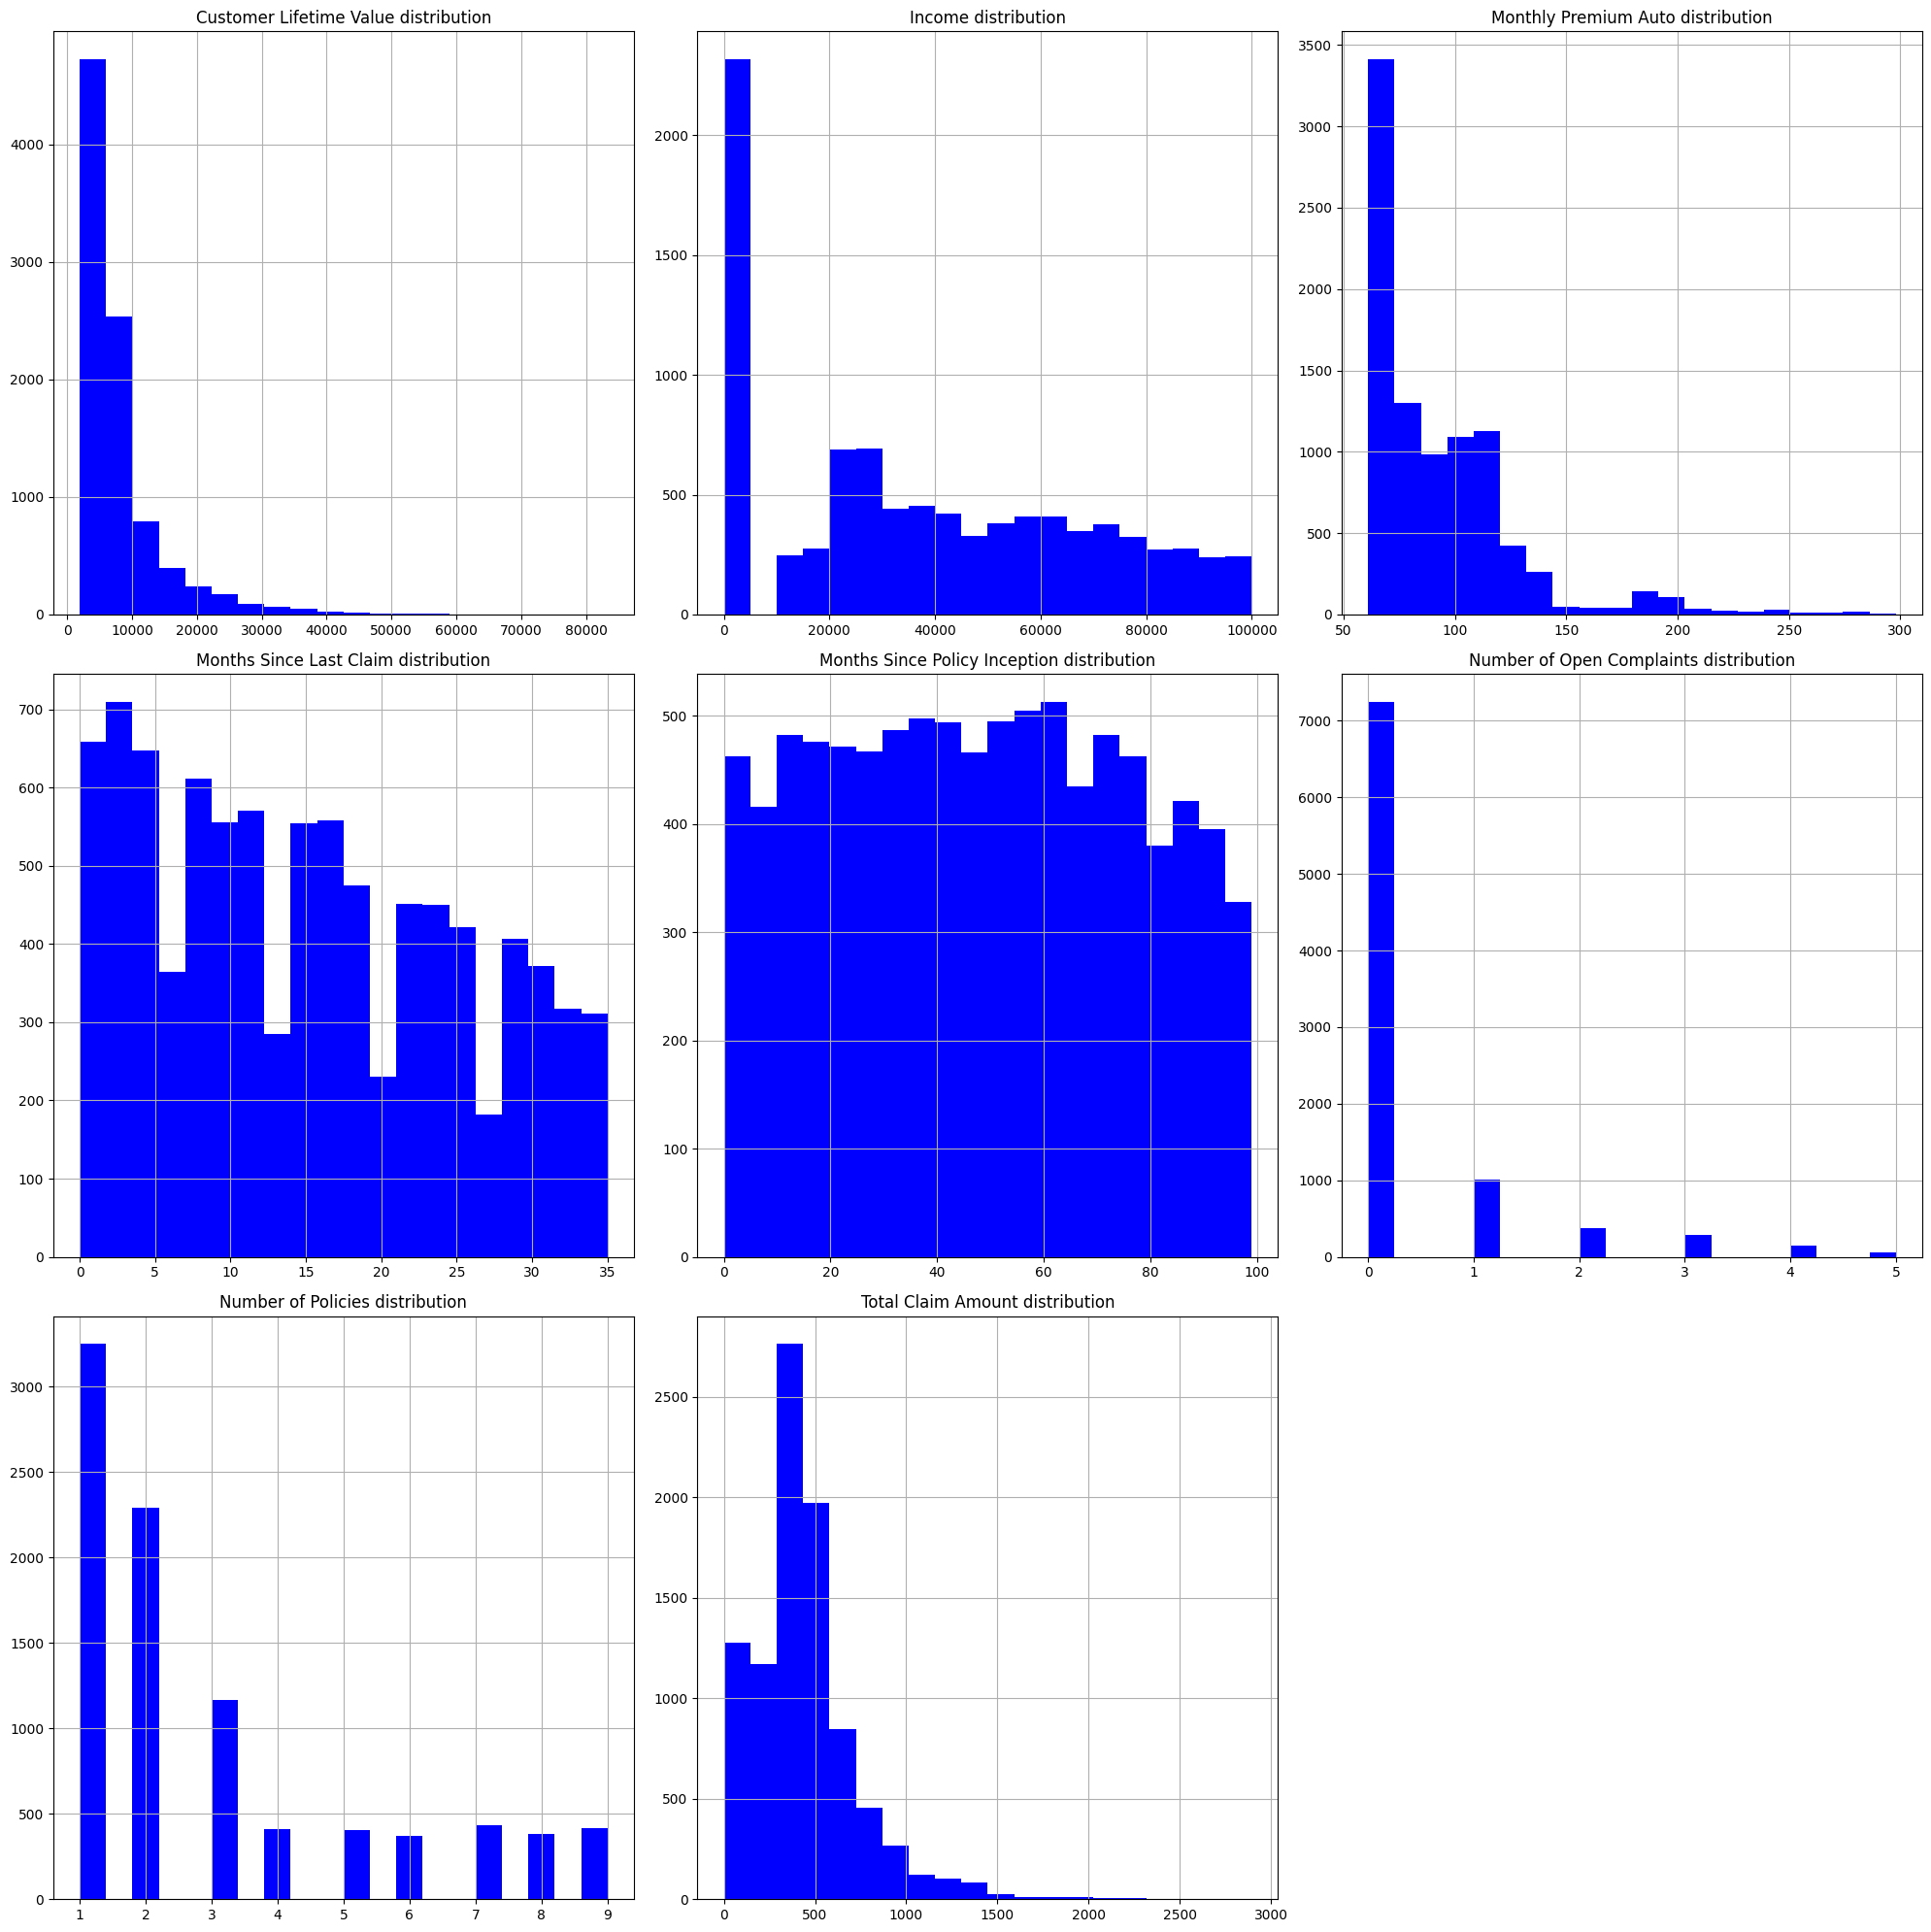

In [9]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='blue')
        ax.set_title(feature+" distribution",color='black')
    fig.tight_layout()  
    plt.show()
histograms_plot(numerical,numerical.columns,3,3)

## Null Values & Duplicates

In [9]:
data.isna().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

No hay null values

In [10]:
duplicates=data[data.duplicated()]
print(f'Hay {len(duplicates)} filas duplicadas en el DataFrame')

Hay 0 filas duplicadas en el DataFrame


## Preprocessing Data - Numerical

Para cada una de las variables numéricas se van a realizar **transformaciones log o sqrt**, en caso de ser necesarias, de forma de que la distribución se aproxime más a una normal. Luego se a realizará un tratamiento de **outliers**.

Log and Sqrt transformation functions

In [11]:
def log_transform_clean_(x):  
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.NAN 

In [12]:
def sqrt_transform_clean_(x):
    if np.isfinite(x) and x>=0:
        return np.sqrt(x)
    else:
        return np.NAN 

### 1) Customer Lifetime Value

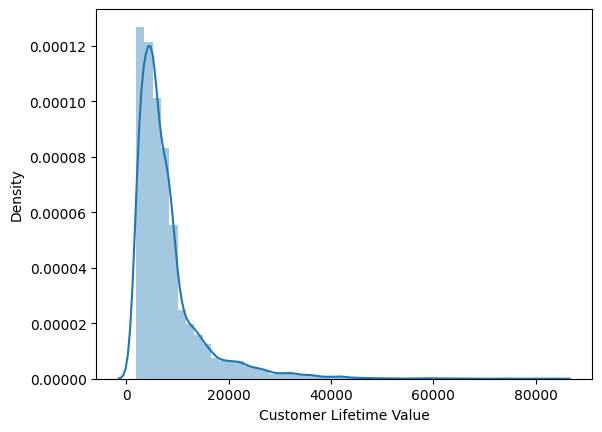

In [13]:
sns.distplot(numerical['Customer Lifetime Value'])
plt.show()

##### Transformations

La distribución tiene skewness positiva. Probemos aplicarle las funciones de logaritmo y raiz cuadrada para ver 
si se aproxima más a una normal

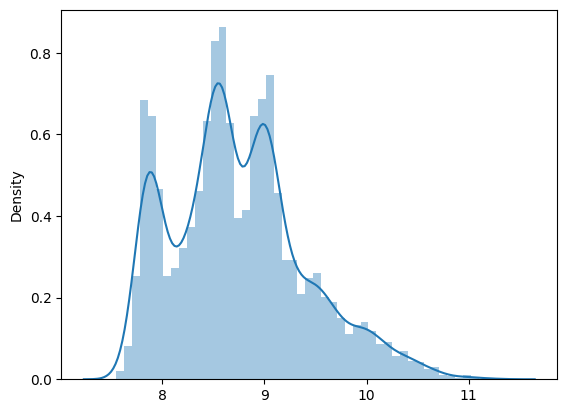

In [14]:
numerical_customerlifetime_log= list(map(log_transform_clean_, numerical['Customer Lifetime Value']))
sns.distplot(numerical_customerlifetime_log)
plt.show()

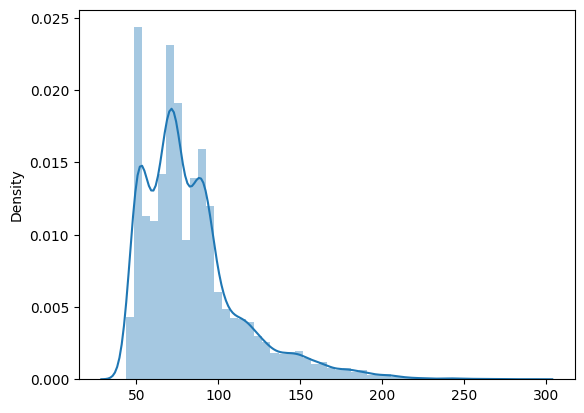

In [15]:
numerical_customerlifetime_sqrt= list(map(sqrt_transform_clean_, numerical['Customer Lifetime Value']))
sns.distplot(numerical_customerlifetime_sqrt)
plt.show()

La del logaritmo se acerca más a una normal --> me quedo con la del log

In [16]:
numerical['numerical_customerlifetime_log']=numerical_customerlifetime_log
numerical=numerical.drop(['Customer Lifetime Value'], axis=1) 

##### Outliers

In [17]:
iqr = np.percentile(numerical['numerical_customerlifetime_log'],75) - np.percentile(numerical['numerical_customerlifetime_log'],25)
upper_limit = np.percentile(numerical['numerical_customerlifetime_log'],75) + 1.5*iqr
print(upper_limit)

10.313001003057334


In [18]:
new_df = numerical[numerical['numerical_customerlifetime_log'] > upper_limit]
len(new_df)

185

In [19]:
points = list(filter(lambda x: x < upper_limit, numerical['numerical_customerlifetime_log']))
len(points)

8949

In [20]:
#Porcentage de datos que se eliminarían
len(new_df)/len(points)*100

2.0672700860431332

2% es un porcentaje pequeño, por lo que se eliminan los outliers.

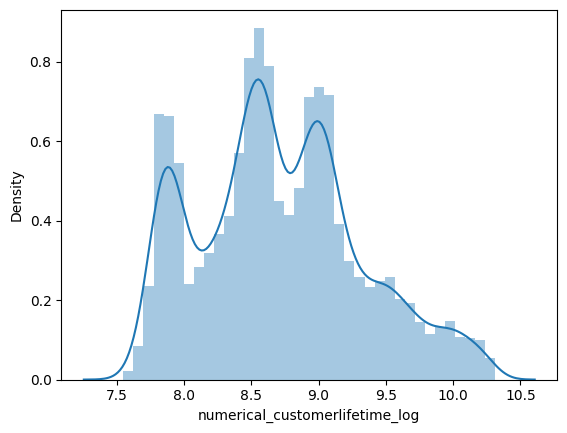

In [21]:
#Eliminando outliers
numerical=numerical[numerical['numerical_customerlifetime_log'] < upper_limit]
sns.distplot(numerical['numerical_customerlifetime_log'])
plt.show() 

### 2) Income

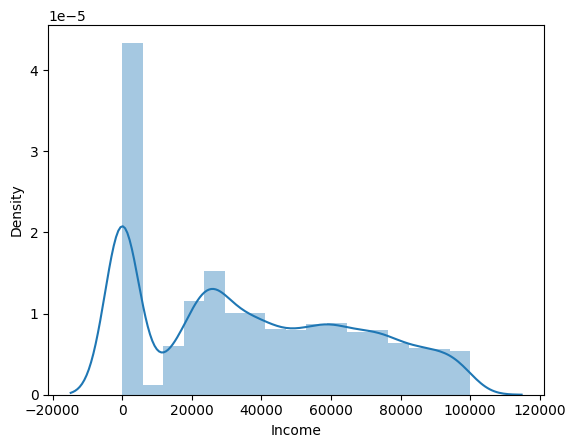

In [22]:
sns.distplot(numerical['Income'])
plt.show()

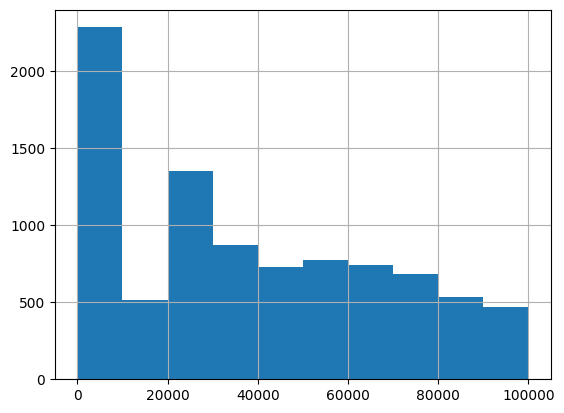

In [23]:
numerical.Income.hist()
plt.show()

Se puede observar que si no fuera por los valores de Income=0 (que se van a estudiar a continuación), la distribución tiene forma uniforme.
Por lo que no se va a realizar tratamiento de outliers porque sería eliminar datos relevantes.

##### Transformations

In [24]:
numerical.Income.value_counts()
#Hay muchos valores de Income nulo. Los vamos a imputar con la media.

Income
0        2282
95697      12
20978       7
26876       7
40864       7
         ... 
70341       1
39187       1
44305       1
39469       1
21941       1
Name: count, Length: 5576, dtype: int64

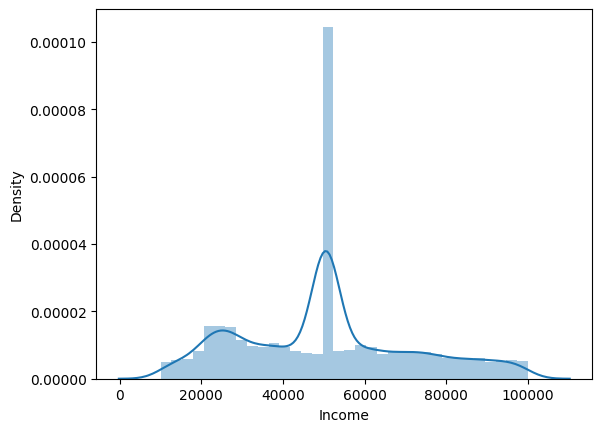

In [25]:
numerical.Income.replace(0, np.nan, inplace=True)
numerical.Income=numerical.Income.fillna(np.mean(numerical.Income))
sns.distplot(numerical.Income)
plt.show()

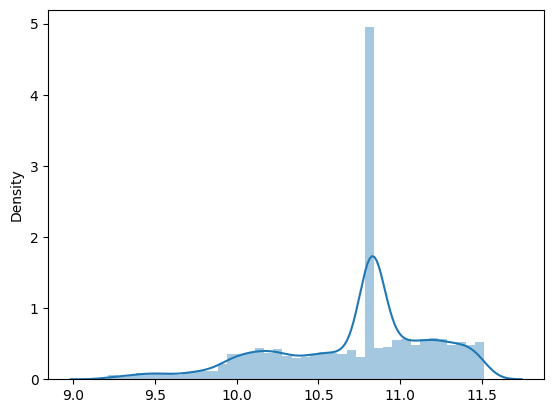

In [26]:
numerical_income_log= list(map(log_transform_clean_, numerical['Income']))
sns.distplot(numerical_income_log)
plt.show()

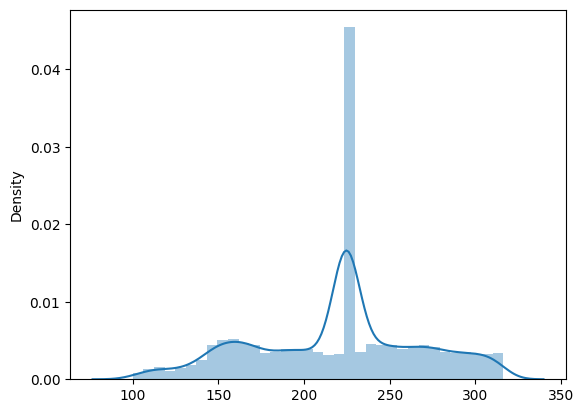

In [27]:
numerical_income_sqrt= list(map(sqrt_transform_clean_, numerical['Income']))
sns.distplot(numerical_income_sqrt)
plt.show()

Se la podría transformar pero no habría muchos cambios por lo que la voy a dejar sin modificar.

### Monthly Premium Auto

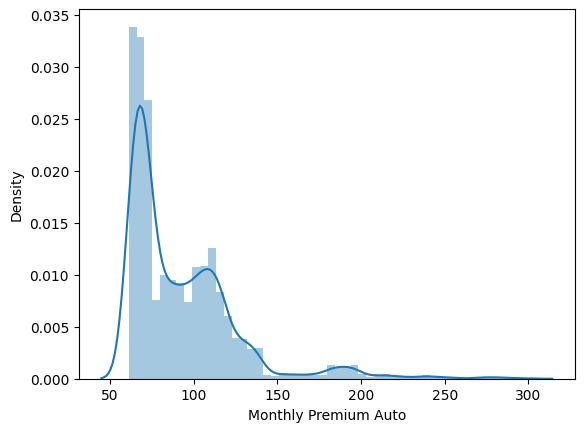

In [28]:
sns.distplot(numerical['Monthly Premium Auto'])
plt.show()

##### Transformations

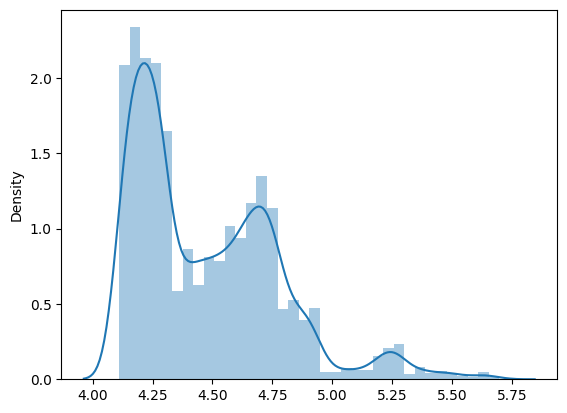

In [29]:
monthly_premium_log= list(map(log_transform_clean_, numerical['Monthly Premium Auto']))
sns.distplot(monthly_premium_log)
plt.show()

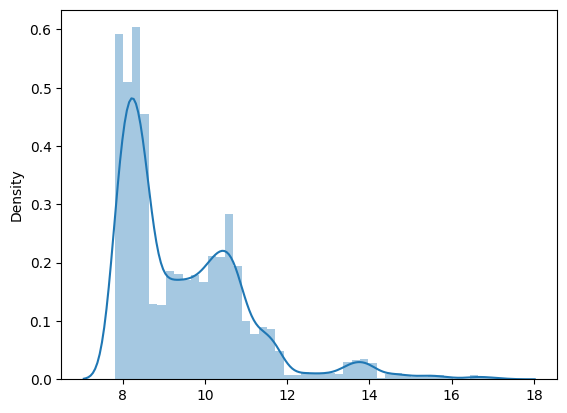

In [30]:
monthly_premium_sqrt= list(map(sqrt_transform_clean_, numerical['Monthly Premium Auto']))
sns.distplot(monthly_premium_sqrt)
plt.show()

In [31]:
#Me quedo con la del logaritmo
numerical['monthly_premium_log']=monthly_premium_log
numerical=numerical.drop(['Monthly Premium Auto'], axis=1) 

##### Outliers

In [32]:
iqr = np.percentile(numerical['monthly_premium_log'],75) - np.percentile(numerical['monthly_premium_log'],25)
upper_limit = np.percentile(numerical['monthly_premium_log'],75) + 1.5*iqr
print(upper_limit)

5.376066510046389


In [33]:
new_df = numerical[numerical['monthly_premium_log'] > upper_limit]
len(new_df)

99

In [34]:
points = list(filter(lambda x: x < upper_limit, numerical['monthly_premium_log']))
len(points)

8850

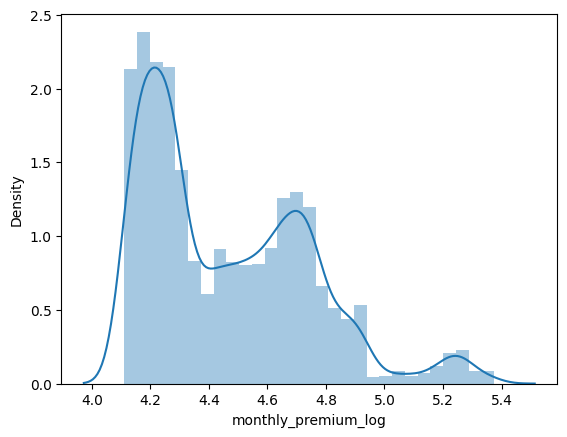

In [35]:
#ELiminando outliers
numerical=numerical[numerical['monthly_premium_log'] < upper_limit]
sns.distplot(numerical['monthly_premium_log'])
plt.show() 

### Months Since Last Claim

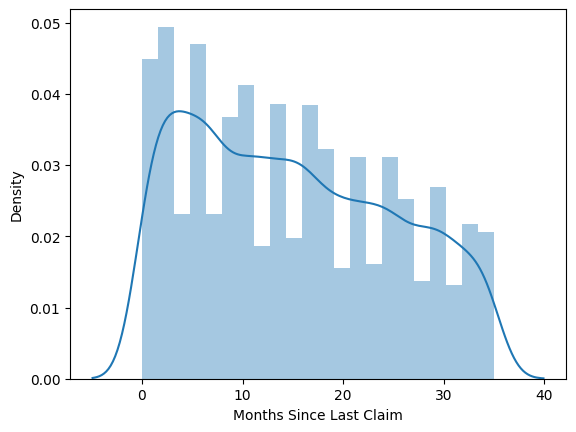

In [36]:
sns.distplot(numerical['Months Since Last Claim'])
plt.show()

##### Transformations

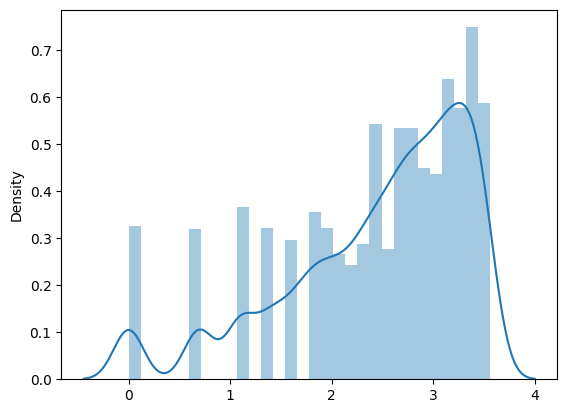

In [37]:
months_since_last_log= list(map(log_transform_clean_, numerical['Months Since Last Claim']))
sns.distplot(months_since_last_log)
plt.show()

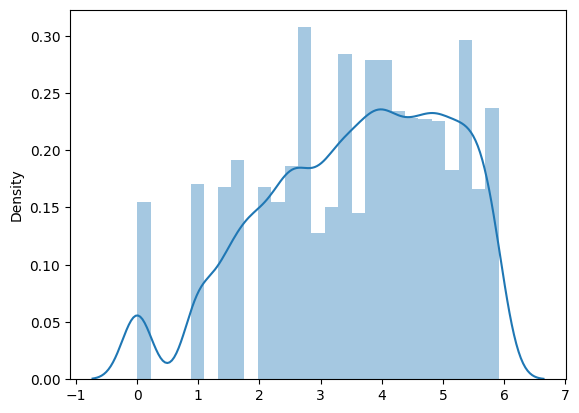

In [38]:
months_since_last_sqrt= list(map(sqrt_transform_clean_, numerical['Months Since Last Claim']))
sns.distplot(months_since_last_sqrt)
plt.show()

Parecerece que la transformación de la raiz es la mejor. Si bien queda esa otra montañita a la izquierda, eliminando outliers se
iría --> Dejo la de la raiz

In [39]:
numerical['months_since_last_sqrt']=months_since_last_sqrt
numerical=numerical.drop(['Months Since Last Claim'], axis=1) 

In [40]:
iqr = np.percentile(numerical['months_since_last_sqrt'],75) - np.percentile(numerical['months_since_last_sqrt'],25)
lower_limit = np.percentile(numerical['months_since_last_sqrt'],75) - 1.5*iqr
print(lower_limit)

1.2763188525184073


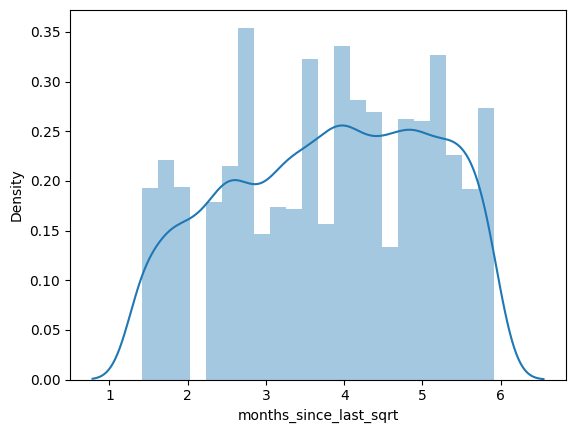

In [41]:
#Eliminando outliers
numerical=numerical[numerical['months_since_last_sqrt'] > lower_limit]
sns.distplot(numerical['months_since_last_sqrt'])
plt.show() 

### Months Since Policy Inception

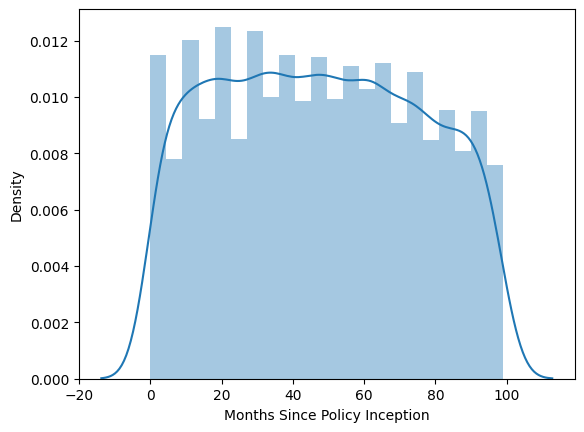

In [42]:
sns.distplot(numerical['Months Since Policy Inception'])
plt.show()

Dada la forma de la gráfica, no se va a modificar dicha variable.

### Number of Open Complaints

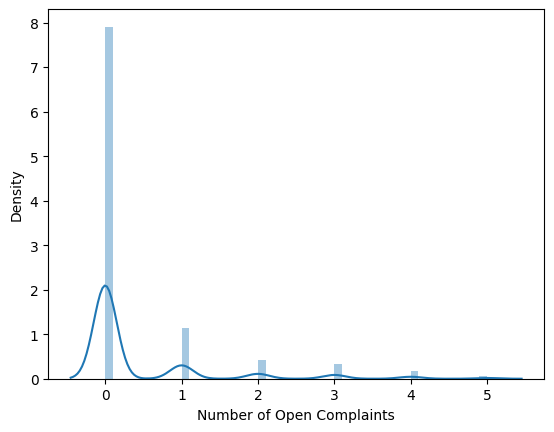

In [43]:
sns.distplot(numerical['Number of Open Complaints'])
plt.show()

##### Transformations

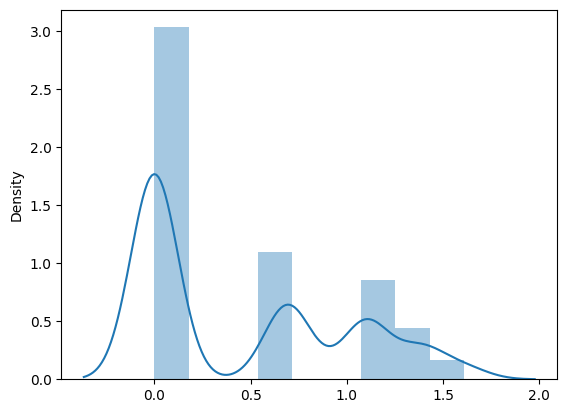

In [44]:
number_open_complaints_log= list(map(log_transform_clean_, numerical['Number of Open Complaints']))
sns.distplot(number_open_complaints_log)
plt.show()

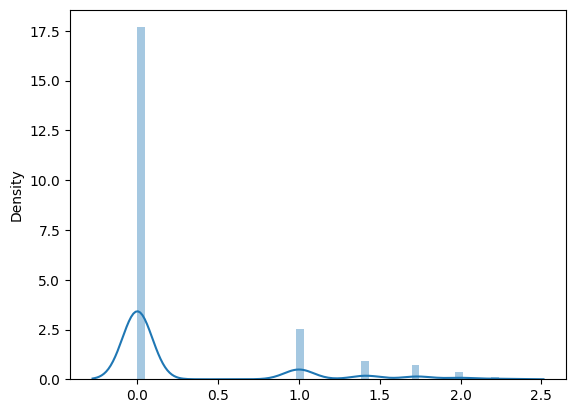

In [45]:
number_open_complaints_sqrt= list(map(sqrt_transform_clean_, numerical['Number of Open Complaints']))
sns.distplot(number_open_complaints_sqrt)
plt.show()

El log daría problemas con los valores nulos. El de la raiz no cambia mucho, por lo que me quedo con el original.

### Number of Policies

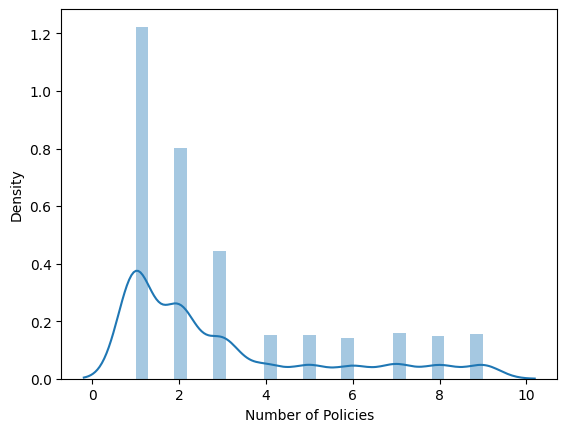

In [46]:
sns.distplot(numerical['Number of Policies'])
plt.show()

##### Transformations

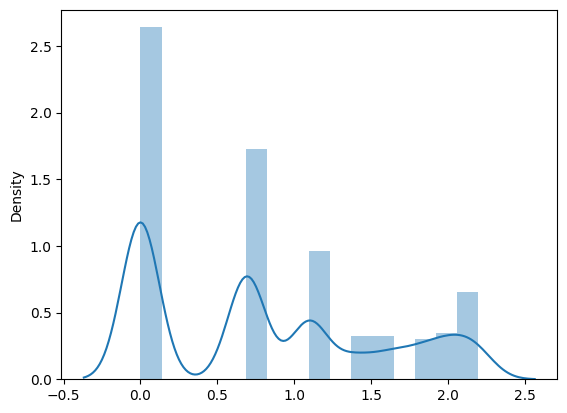

In [47]:
number_policies_log= list(map(log_transform_clean_, numerical['Number of Policies']))
sns.distplot(number_policies_log)
plt.show()

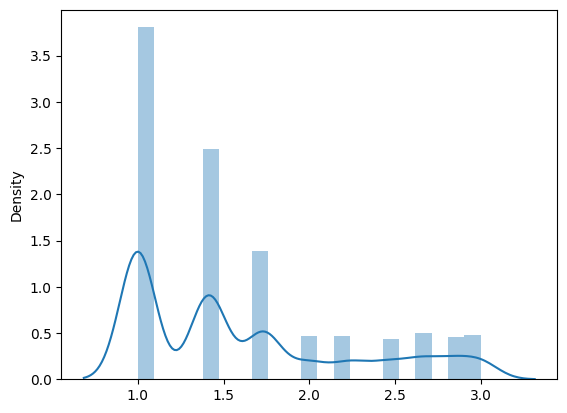

In [48]:
number_policies_sqrt= list(map(sqrt_transform_clean_, numerical['Number of Policies']))
sns.distplot(number_policies_sqrt)
plt.show()

Me quedo con el log

In [49]:
numerical['number_policies_log']=number_policies_log
numerical=numerical.drop(['Number of Policies'], axis=1) 

##### Outliers

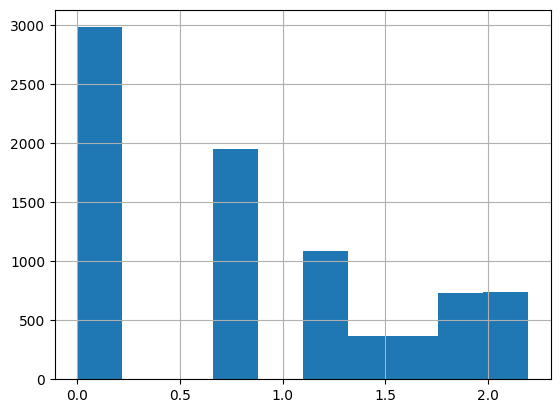

In [50]:
numerical.number_policies_log.hist()
plt.show()

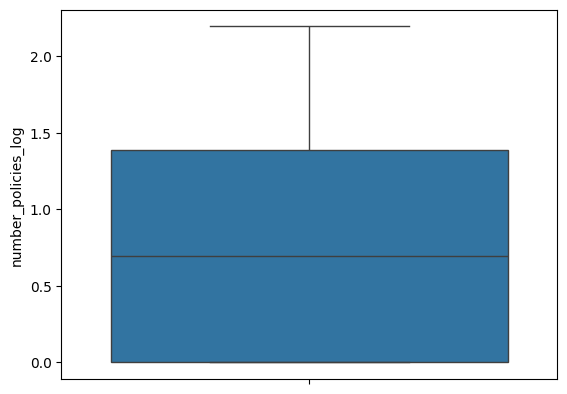

In [51]:
sns.boxplot(numerical.number_policies_log)
plt.show()

In [52]:
iqr = np.percentile(numerical['number_policies_log'],75) - np.percentile(numerical['number_policies_log'],25)
lower_limit = np.percentile(numerical['number_policies_log'],75) - 1.5*iqr
print(lower_limit)

-0.6931471805599452


Dio negativo --> No quito outliers (del lado derecho no quito outliers porque se perderían muchos datos)

In [53]:
numerical.columns

Index(['Income', 'Months Since Policy Inception', 'Number of Open Complaints',
       'Total Claim Amount', 'numerical_customerlifetime_log',
       'monthly_premium_log', 'months_since_last_sqrt', 'number_policies_log'],
      dtype='object')

### Total Claim Amount

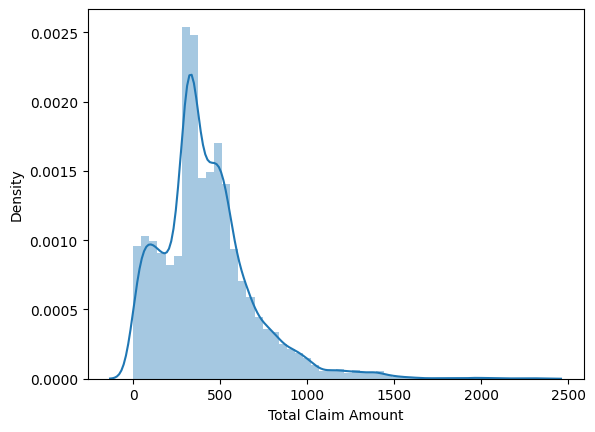

In [54]:
sns.distplot(numerical['Total Claim Amount'])
plt.show()

##### Transformations

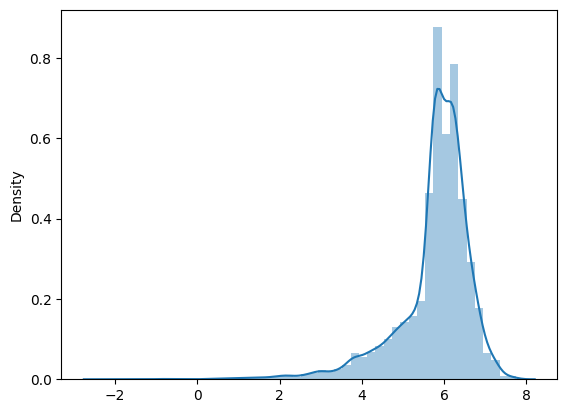

In [55]:
total_claim_log= list(map(log_transform_clean_, numerical['Total Claim Amount']))
sns.distplot(total_claim_log)
plt.show()

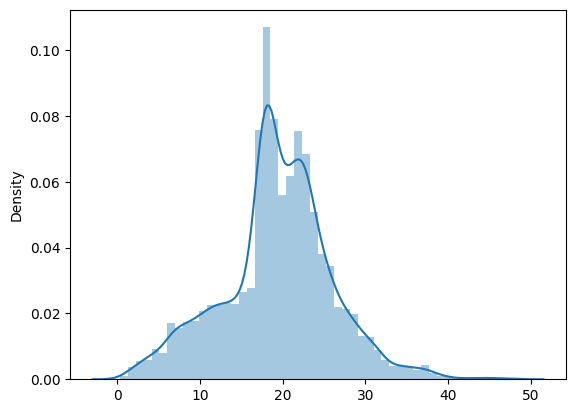

In [56]:
total_claim_sqrt= list(map(sqrt_transform_clean_, numerical['Total Claim Amount']))
sns.distplot(total_claim_sqrt)
plt.show()

Me quedo con el de la raiz

In [57]:
numerical['total_claim_sqrt']=total_claim_sqrt
numerical=numerical.drop(['Total Claim Amount'], axis=1) 

##### Outliers

In [58]:
iqr = np.percentile(numerical['total_claim_sqrt'],75) - np.percentile(numerical['total_claim_sqrt'],25)
upper_limit = np.percentile(numerical['total_claim_sqrt'],75) + 1.5*iqr
print(upper_limit)

33.38784325323111


Viendo la gráfica, no convendría eliminar desde ese upper limit porque se perderían muchos valores. Probemos
poner el +3iqr en la ecuación

In [59]:
iqr = np.percentile(numerical['total_claim_sqrt'],75) - np.percentile(numerical['total_claim_sqrt'],25)
upper_limit_2 = np.percentile(numerical['total_claim_sqrt'],75) + 3*iqr
print(upper_limit_2)

43.58948371255913


Este valor tiene más sentido --> Eliminemos outliers a partir del upper_limit_2

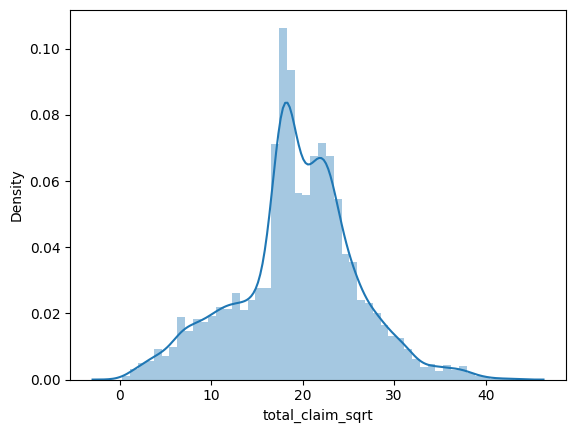

In [60]:
#Eliminando outliers
numerical=numerical[numerical['total_claim_sqrt'] < upper_limit_2]
sns.distplot(numerical['total_claim_sqrt'])
plt.show()

Veamos como quedaron las columnas luego de las transformaciones

In [61]:
numerical.columns

Index(['Income', 'Months Since Policy Inception', 'Number of Open Complaints',
       'numerical_customerlifetime_log', 'monthly_premium_log',
       'months_since_last_sqrt', 'number_policies_log', 'total_claim_sqrt'],
      dtype='object')

## Normalize columns

In [62]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler

In [63]:
numerical.sample()

,Income,Months Since Policy Inception,Number of Open Complaints,numerical_customerlifetime_log,monthly_premium_log,months_since_last_sqrt,number_policies_log,total_claim_sqrt
3551,50448.747113,18,0,8.977125,4.248495,3.605551,0.693147,18.330303


Primero pasemos todos los títulos de las columnas a minúsculas para que quede más prolijo

In [64]:
numerical.columns=numerical.columns.str.lower()
numerical.columns

Index(['income', 'months since policy inception', 'number of open complaints',
       'numerical_customerlifetime_log', 'monthly_premium_log',
       'months_since_last_sqrt', 'number_policies_log', 'total_claim_sqrt'],
      dtype='object')

In [65]:
Y=numerical["total_claim_sqrt"]
X=numerical.drop(["total_claim_sqrt"], axis=1)

##### Escalar

In [66]:
transformer=MinMaxScaler().fit(X)
transformer
x_scaled=transformer.transform(X)
print(x_scaled.shape)
pd.DataFrame(x_scaled)

(8204, 7)


,0,1,2,3,4,5,6
0,0.514064,0.050505,0.0,0.135910,0.097463,0.942418,0.000000
1,0.449299,0.424242,0.0,0.471063,0.341996,0.486762,0.946395
2,0.430601,0.383838,0.0,0.692913,0.451800,0.628279,0.315465
3,0.449299,0.656566,0.0,0.504048,0.437016,0.628279,0.885622
4,0.375778,0.444444,0.0,0.142418,0.142032,0.455342,0.000000
...,...,...,...,...,...,...,...
8199,0.688250,0.898990,0.0,0.908784,0.142032,0.628279,0.315465
8200,0.128602,0.282828,0.0,0.177066,0.204503,0.516995,0.000000
8201,0.449299,0.373737,0.6,0.527763,0.262398,0.352251,0.315465
8202,0.132349,0.030303,0.0,0.498257,0.358647,0.981091,0.500000


In [67]:
pd.DataFrame(x_scaled).describe()

,0,1,2,3,4,5,6
count,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000
mean,0.449876,0.480725,0.077767,0.416198,0.276776,0.533167,0.365207
std,0.232989,0.281528,0.182651,0.216319,0.222608,0.283129,0.339292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.273075,0.242424,0.000000,0.259723,0.085917,0.314139,0.000000
50%,0.449299,0.474747,0.000000,0.394182,0.224276,0.546167,0.315465
75%,0.579936,0.717172,0.000000,0.548302,0.444442,0.774071,0.630930
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Normalizar

In [68]:
transformer=StandardScaler().fit(X)
x_normalized=transformer.transform(X)
print(x_normalized.shape)
pd.DataFrame(x_normalized)

(8204, 7)


,0,1,2,3,4,5,6
0,0.275515,-1.528251,-0.425793,-1.295794,-0.805560,1.445545,-1.076446
1,-0.002478,-0.200641,-0.425793,0.253645,0.292996,-0.163912,1.713046
2,-0.082734,-0.344166,-0.425793,1.279277,0.786286,0.335950,-0.146616
3,-0.002478,0.624631,-0.425793,0.406138,0.719872,0.335950,1.533918
4,-0.318051,-0.128878,-0.425793,-1.265703,-0.605336,-0.274893,-1.076446
...,...,...,...,...,...,...,...
8199,1.023176,1.485783,-0.425793,2.277262,-0.605336,0.335950,-0.146616
8200,-1.379007,-0.702980,-0.425793,-1.105523,-0.324688,-0.057122,-1.076446
8201,-0.002478,-0.380048,2.859353,0.515774,-0.064594,-0.639028,-0.146616
8202,-1.362925,-1.600014,-0.425793,0.379366,0.367799,1.582142,0.397300


In [69]:
pd.DataFrame(x_normalized).describe()

,0,1,2,3,4,5,6
count,8.204000e+03,8.204000e+03,8.204000e+03,8.204000e+03,8.204000e+03,8.204000e+03,8.204000e+03
mean,1.387643e-16,1.218214e-16,-6.149261e-17,1.681303e-16,1.504431e-16,8.447114e-17,-2.490018e-18
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00
min,-1.931008e+00,-1.707658e+00,-4.257930e-01,-1.924114e+00,-1.243409e+00,-1.883240e+00,-1.076446e+00
25%,-7.588834e-01,-8.465054e-01,-4.257930e-01,-7.233947e-01,-8.574300e-01,-7.736449e-01,-1.076446e+00
50%,-2.477805e-03,-2.123404e-02,-4.257930e-01,-1.017809e-01,-2.358574e-01,4.591614e-02,-1.466157e-01
75%,5.582559e-01,8.399187e-01,-4.257930e-01,6.107283e-01,7.532344e-01,8.509149e-01,7.832149e-01
max,2.361301e+00,1.844597e+00,5.049451e+00,2.698962e+00,3.249060e+00,1.648934e+00,1.871047e+00


##### Heatmap

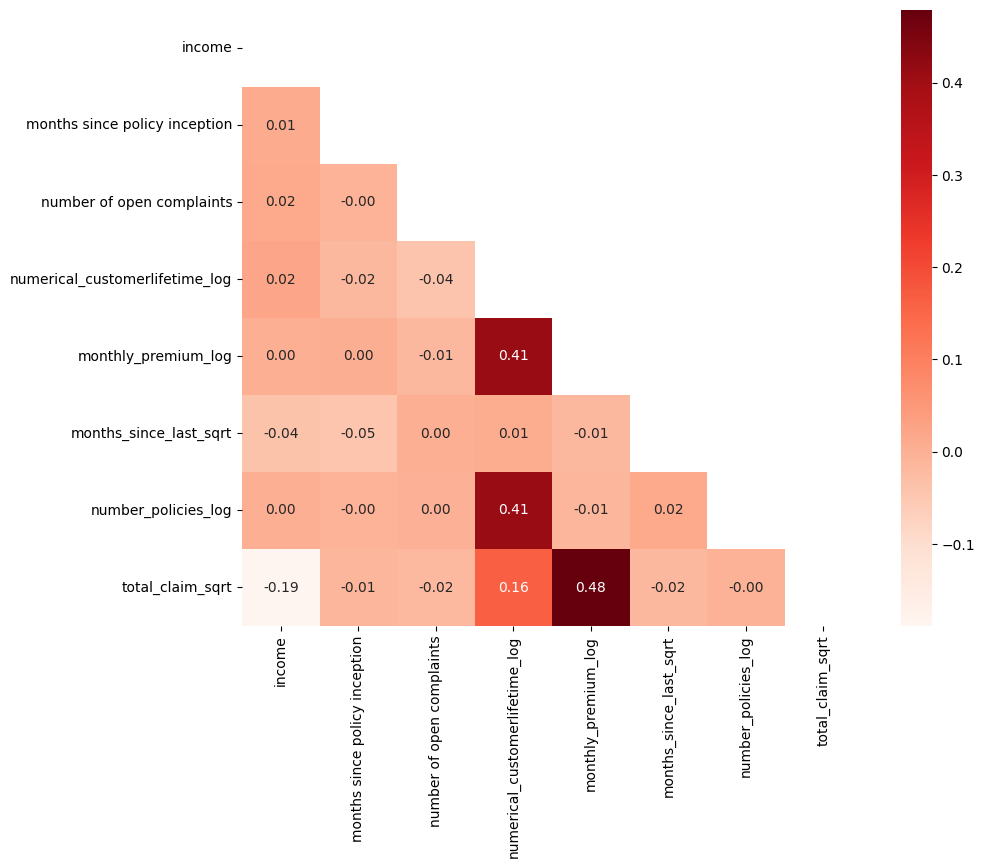

In [70]:
correlation_matrix=numerical.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='Reds', fmt='.2f')
plt.show()

##### Matriz de correlación

In [71]:
numerical.corr()

,income,months since policy inception,number of open complaints,numerical_customerlifetime_log,monthly_premium_log,months_since_last_sqrt,number_policies_log,total_claim_sqrt
income,1.000000,0.010862,0.015634,0.023309,0.003134,-0.037938,0.003723,-0.188886
months since policy inception,0.010862,1.000000,-0.004764,-0.016637,0.004915,-0.045143,-0.004412,-0.009027
number of open complaints,0.015634,-0.004764,1.000000,-0.042153,-0.014794,0.003293,0.000416,-0.018083
numerical_customerlifetime_log,0.023309,-0.016637,-0.042153,1.000000,0.408611,0.008092,0.409719,0.163849
monthly_premium_log,0.003134,0.004915,-0.014794,0.408611,1.000000,-0.014443,-0.009060,0.479016
months_since_last_sqrt,-0.037938,-0.045143,0.003293,0.008092,-0.014443,1.000000,0.015530,-0.015696
number_policies_log,0.003723,-0.004412,0.000416,0.409719,-0.009060,0.015530,1.000000,-0.002384
total_claim_sqrt,-0.188886,-0.009027,-0.018083,0.163849,0.479016,-0.015696,-0.002384,1.000000


## Linear Regressions

#### Statsmodels

Scaled:

In [72]:
X = sm.add_constant(x_scaled)
model = sm.OLS(Y,X).fit()

print(model.summary())
print("R2:", model.rsquared.round(2))

                            OLS Regression Results                            
Dep. Variable:       total_claim_sqrt   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     427.4
Date:                Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                        23:16:24   Log-Likelihood:                -25832.
No. Observations:                8204   AIC:                         5.168e+04
Df Residuals:                    8196   BIC:                         5.174e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.4407      0.249     74.074      0.0

Normalized:

In [73]:
X = sm.add_constant(x_normalized)
model = sm.OLS(Y,X).fit()

print(model.summary())
print("R2:", model.rsquared.round(2))

                            OLS Regression Results                            
Dep. Variable:       total_claim_sqrt   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     427.4
Date:                Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                        23:16:24   Log-Likelihood:                -25832.
No. Observations:                8204   AIC:                         5.168e+04
Df Residuals:                    8196   BIC:                         5.174e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.3427      0.062    310.506      0.0

#### sklearn

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [75]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
print("R2 value is = ",round(lm.score(X_train, y_train),2)) 

R2 value is =  0.26


In [76]:
predictions=lm.predict(X_test)
R2=r2_score(y_test, predictions)
print(R2.round(2))

0.29


Scaled:

In [77]:
lm = linear_model.LinearRegression()
model = lm.fit(x_scaled,Y)
print("R2 value is = ",round(lm.score(x_scaled,Y),2)) 
predictions=lm.predict(x_scaled)

R2 value is =  0.27


Normalized:

In [78]:
lm = linear_model.LinearRegression()
model = lm.fit(x_normalized,Y)
print("R2 value is = ",round(lm.score(x_normalized,Y),2)) 
predictions=lm.predict(x_normalized)

R2 value is =  0.27


- Todos los resultados dieron muy similares. Los R2 dieron alrededor de 0.28. Esto indica que probablemente se deba porder mejorar
  el modelo. Hay 2 variables con p-values de 0.3 aproximadamente. Son las que tienen valor más alto.

- Lo que es positivo es los resultados de statsmodels y sklearn dieron casi iguales.